# Privacy-Preserving Detection of COVID-19 in X-Ray Images (PATE)

###### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [2]:
!wget -nc https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py

--2021-05-18 12:59:12--  https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17194 (17K) [text/plain]
Saving to: ‘pate.py’

pate.py             100%[===================>]  16.79K  --.-KB/s    in 0.001s  

2021-05-18 12:59:13 (13.3 MB/s) - ‘pate.py’ saved [17194/17194]



##### Import libraries

In [3]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from pate import perform_analysis
from progressbar import ProgressBar

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D


##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [4]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:06, 125MB/s]


##### Define constants

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 16
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# PATE parameters
TEACHER_NB = 50
EPOCHS_TEACHER = 80
NOISE_SCALE = 10.0
NOISE_EPSILON = 1 / NOISE_SCALE


# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Create dataset

In [6]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [7]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [8]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [9]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [10]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=SPLIT, random_state=random_state)

In [11]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [12]:
TRAIN_IMG_COUNT = len(y_train)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7684, Test: 1356


In [13]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4607, 'COVID-19': 3077}
test set:   {'normal': 817, 'COVID-19': 539}


###### Dataset partition for teachers

In [14]:
def partition_dataset(train_set, nb_teachers, teacher_id):
    # Get sets
    train_data, train_labels = train_set

    # Sanity check
    assert len(train_data) == len(train_labels)
    assert int(teacher_id) < int(nb_teachers)

    # This will floor the possible number of batches
    train_batch_len = int(len(train_data) / nb_teachers)
    assert train_batch_len >= 16

    # Compute start, end indices of partition
    train_start = teacher_id * train_batch_len
    train_end = (teacher_id+1) * train_batch_len

    # Slice partition off
    train_partition = (train_data[train_start:train_end], train_labels[train_start:train_end])

    return train_partition

In [15]:
teacher_data = [partition_dataset((x_train,y_train), TEACHER_NB, teacher_id) for teacher_id in range(0, TEACHER_NB)]
print("Teacher partitions: " + str(len(teacher_data)))
print("Length first train: " + str(len(teacher_data[0][1])))
#print("Teacher 0: " + str(teacher_data[0]))

Teacher partitions: 50
Length first train: 153


###### Create tensors

In [16]:
# build tensorflow datasets
teacher_files = []
for teacher_id in range(0, TEACHER_NB):
    train_set = teacher_data[teacher_id]
    teacher_files.append(tf.data.Dataset.from_tensor_slices(train_set))

test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# split test files into unlabeld train and labeled test data for student
split = 3 * BATCH_SIZE * EPOCHS
student_unlabeled_files = tf.data.Dataset.from_tensor_slices((x_test[:split], y_test[:split]))
student_test_files = tf.data.Dataset.from_tensor_slices((x_test[split:], y_test[split:]))
STUDENT_TRAIN_LENGTH = tf.data.experimental.cardinality(student_unlabeled_files).numpy()
print("Length student unlabeled: " + str(STUDENT_TRAIN_LENGTH))
print("Length student test: \t  " + str(tf.data.experimental.cardinality(student_test_files).numpy()))

Length student unlabeled: 960
Length student test: 	  396


###### Image retrieval

In [17]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [18]:
teacher_sets = []
for teacher_id in range(0, TEACHER_NB):
    train_files = teacher_files[teacher_id]
    teacher_sets.append(train_files.map(get_img, num_parallel_calls=AUTOTUNE))

test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

student_unlabeled_ds = student_unlabeled_files.map(get_img, num_parallel_calls=AUTOTUNE)
student_test_ds = student_test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing and data augmentation

In [19]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  Rescaling(scale=1./255)
])

In [20]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [21]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [22]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [23]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [24]:
# teachers
TEACHER_IMG_CNTS = []
teacher_batched = []
for teacher_id in range(0, TEACHER_NB):
    train_ds = teacher_sets[teacher_id]
    TEACHER_IMG_CNTS.append(tf.data.experimental.cardinality(train_ds).numpy())
    teacher_batched.append(prepare_dataset(train_ds, 
                                               pre=True,
                                               shuffle=True, 
                                               repeat=True, 
                                               augment=True, 
                                               batch=True,
                                               cache='./data.tfcache_'+str(teacher_id)))

test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [25]:
# student
student_unlabeled = prepare_dataset(student_unlabeled_ds,
                                    pre=True,
                                    shuffle=True,
                                    repeat=False,
                                    batch=False,
                                    augment=False)
# seperate labels from images
student_data = np.array([x[0] for x in list(tf.data.Dataset.as_numpy_iterator(student_unlabeled))])
student_labels = np.array([x[1] for x in list(tf.data.Dataset.as_numpy_iterator(student_unlabeled))])

student_test_batched = prepare_dataset(student_test_ds,
                                       pre=True,
                                       shuffle=False,
                                       repeat=False,
                                       batch=True,
                                       augment=False)

In [26]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=True, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=True, # TODO batching needed?
                                augment=False)
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [27]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

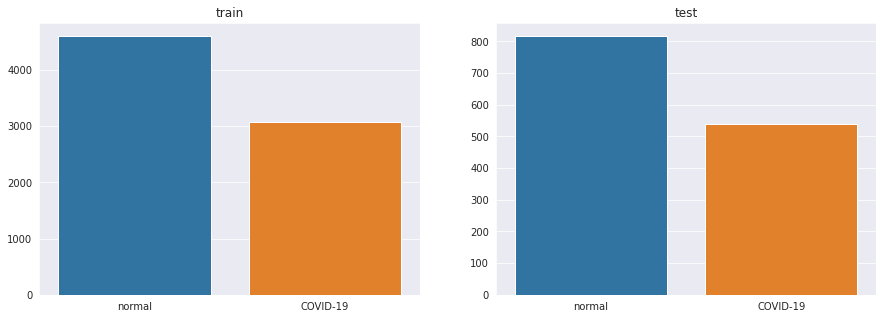

In [28]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [29]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [30]:
image_batch, label_batch = next(iter(teacher_batched[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


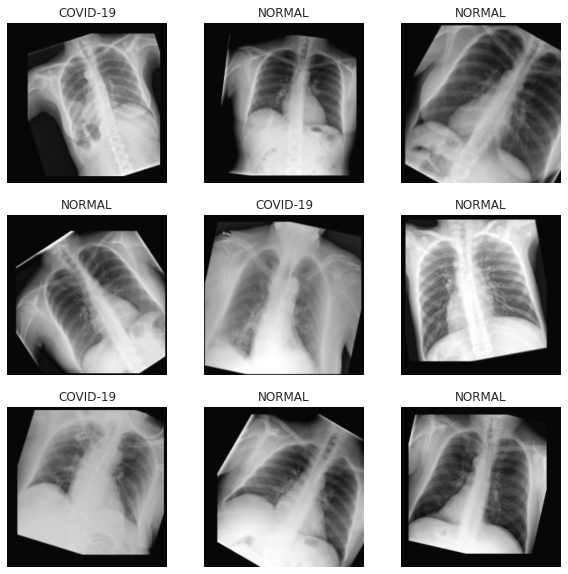

In [31]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

Define class weights

In [32]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [33]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## Teacher training

### Model definition

In [34]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('relu', name=name + '_preact_relu')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('relu', name='post_relu')(x)
    # Create model.
    model = tf.keras.models.Model(input, x, name=model_name)
    return model

def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2')
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [35]:
def resnet18_builder():
    # get ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    
    model = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dropout(0.2, name='Dropout'), # add dropout (inspired by inception-resnet-v2)
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet18V2')

    return model

In [36]:
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

teacher_models = []
for teacher_id in range(0, TEACHER_NB):
    teacher_models.append(resnet18_builder())
    teacher_models[teacher_id].compile(
        optimizer=Adam(lr=1e-3),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
teacher_models[0].summary()

Model: "ResNet18V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18v2 (Functional)      (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [38]:
pbar = ProgressBar()
teacher_histories = []
for teacher_id in pbar(range(0, TEACHER_NB)):
    teacher_histories.append(teacher_models[teacher_id].fit(
        teacher_batched[teacher_id],
        steps_per_epoch=TEACHER_IMG_CNTS[teacher_id] // BATCH_SIZE,
        epochs=EPOCHS_TEACHER,
        class_weight=class_weight_dict, # TODO one dict for each teacher?
        callbacks=[learning_rate_decay],
        verbose=0,
    ))

100% (50 of 50) |########################| Elapsed Time: 1:55:43 Time:  1:55:43


### Evaluation on test set

In [39]:
for teacher_id in range(0, TEACHER_NB):
    print("Teacher %d"%(teacher_id))
    loss, acc, prec, rec = teacher_models[teacher_id].evaluate(test_batched)

Teacher 0
85/85 [==============================] - 5s 56ms/step - loss: 0.4965 - accuracy: 0.7670 - precision: 0.6591 - recall: 0.8571
Teacher 1
85/85 [==============================] - 2s 19ms/step - loss: 0.5678 - accuracy: 0.7338 - precision: 0.6369 - recall: 0.7681
Teacher 2
85/85 [==============================] - 2s 18ms/step - loss: 0.5035 - accuracy: 0.7581 - precision: 0.7017 - recall: 0.6809
Teacher 3
85/85 [==============================] - 2s 17ms/step - loss: 0.4802 - accuracy: 0.7611 - precision: 0.6850 - recall: 0.7384
Teacher 4
85/85 [==============================] - 2s 18ms/step - loss: 0.5103 - accuracy: 0.7552 - precision: 0.7010 - recall: 0.6698
Teacher 5
85/85 [==============================] - 2s 18ms/step - loss: 0.5271 - accuracy: 0.7271 - precision: 0.6361 - recall: 0.7328
Teacher 6
85/85 [==============================] - 2s 18ms/step - loss: 0.5132 - accuracy: 0.7854 - precision: 0.7000 - recall: 0.8052
Teacher 7
85/85 [==============================] - 2s 1

## Aggregate student dataset

In [40]:
def ensemble_preds(nb_teachers, data):
  # Compute shape of array that will hold probabilities produced by each
  # teacher, for each training point, and each output class
  result_shape = (nb_teachers, len(data))
  # Create array that will hold result
  result = np.zeros(result_shape, dtype=np.float32)

  # Get predictions from each teacher
  pbar = ProgressBar()
  for teacher_id in pbar(range(0, nb_teachers)):
    # Get predictions on our training data and store in result array
    result[teacher_id] = [x[0] for x in teacher_models[teacher_id].predict(data, verbose=0)]

  return result

In [41]:
# get teacher predictions
teacher_preds = ensemble_preds(TEACHER_NB, student_data)
# turn probs into labels
teacher_preds = np.asarray(np.round(teacher_preds), dtype=np.int32)

100% (50 of 50) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


In [42]:
def aggregate_noisy_max(preds, lap_scale):
  preds = preds.T
  labels = []
  #beta = 1 / epsilon # same as lap scale??
  for pred in preds:
    label_count = np.bincount(pred, minlength = 2)
    # convert to float for laplace
    label_count = np.asarray(label_count, dtype=np.float32)
    for i in range(len(label_count)):
      label_count[i] += np.random.laplace(loc=0.0, scale=lap_scale)
    noisy_labels = np.argmax(label_count)
    labels.append(noisy_labels)

  labels = np.asarray(labels, dtype=np.int32)
  return labels

In [43]:
# aggregate and add noise
aggregated_labels = aggregate_noisy_max(teacher_preds, NOISE_SCALE)

In [44]:
# test ensemble accuracy
assert len(aggregated_labels) == len(student_labels)
# Check against correct labels to compute correct guesses
correct = np.sum(aggregated_labels == student_labels.reshape(len(student_labels)))
# Divide by number of labels to obtain accuracy
agg_acc = float(correct) / len(student_labels)
print("Accuracy of the aggregated labels: " + str(agg_acc))

Accuracy of the aggregated labels: 0.5083333333333333


In [45]:
student_aggregated_ds = tf.data.Dataset.from_tensor_slices((student_data, aggregated_labels))
student_aggregated_batched = prepare_dataset(student_aggregated_ds,
                                             pre=False,
                                             shuffle=False,
                                             repeat=False,
                                             augment=True,
                                             batch=True,
                                             cache='./data.tfcache_agg')

## Student model (ResNet18V2)
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [46]:
resnet18 = resnet18_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet18.compile(
    optimizer=Adam(lr=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [47]:
resnet18.summary()

Model: "ResNet18V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18v2 (Functional)      (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [48]:
history_resnet18 = resnet18.fit(
    student_aggregated_batched,
    steps_per_epoch=STUDENT_TRAIN_LENGTH // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
60/60 [==============================] - 15s 206ms/step - loss: 0.5535 - accuracy: 0.7081 - precision: 0.6468 - recall: 0.8486
Epoch 2/20
60/60 [==============================] - 11s 187ms/step - loss: 0.4285 - accuracy: 0.8050 - precision: 0.7655 - recall: 0.8357
Epoch 3/20
60/60 [==============================] - 12s 186ms/step - loss: 0.4034 - accuracy: 0.8197 - precision: 0.7816 - recall: 0.8493
Epoch 4/20
60/60 [==============================] - 11s 185ms/step - loss: 0.4106 - accuracy: 0.8131 - precision: 0.7773 - recall: 0.8370
Epoch 5/20
60/60 [==============================] - 11s 185ms/step - loss: 0.3913 - accuracy: 0.8195 - precision: 0.7856 - recall: 0.8422
Epoch 6/20
60/60 [==============================] - 11s 186ms/step - loss: 0.3550 - accuracy: 0.8465 - precision: 0.8262 - recall: 0.8487
Epoch 7/20
60/60 [==============================] - 11s 185ms/step - loss: 0.3581 - accuracy: 0.8446 - precision: 0.8041 - recall: 0.8794
Epoch 8/20
60/60 [================

### Evaluation

###### Visualize performance

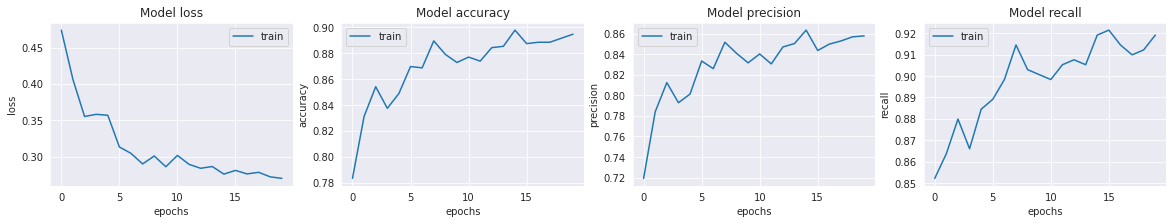

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [50]:
loss, acc, prec, rec = resnet18.evaluate(student_test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

25/25 [==============================] - 4s 138ms/step - loss: 0.6000 - accuracy: 0.8005 - precision: 0.7126 - recall: 0.7933
Loss of the model is -  0.5999848246574402
Accuracy of the model is -  80.05050420761108 %
Precision of the model is -  0.71257483959198
Recall of the model is -  0.7933333516120911


## Privacy

### Compute epsilon

In [51]:
# delta rule of thumb: set to less than the inverse of the training data size (1 / TRAIN_IMG_COUNT)
DELTA = 1e-4
print('Delta = %.e'%(DELTA))

Delta = 1e-04


In [52]:
dde, die = perform_analysis(
    teacher_preds=teacher_preds,
    indices=aggregated_labels,
    noise_eps=NOISE_EPSILON,
    delta=DELTA,
    moments=8,
    beta=0.09
)
print("Data dependent epsilon = ", dde)
print("Data independent epsilon = ", die)

Data dependent epsilon =  13.765159439585082
Data independent epsilon =  47.610340371976186


### Attacks

###### Membership Inference Attack

In [53]:
!pip install tensorflow-privacy

     |████████████████████████████████| 194kB 5.0MB/s 


In [54]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

In [55]:
print('Predict on train...')
probs_train = resnet18.predict(x_train_attack)
print('Predict on test...')
probs_test = resnet18.predict(x_test_attack)

# only label as output instead of prob
#probs_train = np.round(logits_train)
#probs_test = np.round(logits_test)


print('Compute losses...')
bc = tf.keras.backend.binary_crossentropy
constant = tf.keras.backend.constant

loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

train_labels = np.array(y_train_attack)
test_labels = np.array(y_test_attack)

Predict on train...
Predict on test...
Compute losses...


Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 53 training and 53 test examples) achieved an AUC of 0.71 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 53 training and 53 test examples) achieved an advantage of 0.42 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 153 training and 153 test examples) achieved an AUC of 0.60
  THRESHOLD_ATTACK (with 153 training and 153 test examples) achieved an advantage of 0.30

Best-performing atta

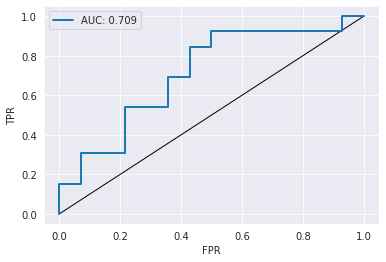

In [56]:
attack_input = AttackInputData(
  logits_train = probs_train,
  logits_test = probs_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
] 

# Run several attacks for different data slices
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

# Plot the ROC curve of the best classifier
plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices=True))